LinearRegression → CV RMSE = 7.5687
Ridge           → CV RMSE = 7.5334
Lasso           → CV RMSE = 7.6566
ElasticNet      → CV RMSE = 7.6257
RandomForest    → CV RMSE = 144.0204

[LinearRegression] Test MSE=8.5985, MAE=2.2595, R²=0.9987


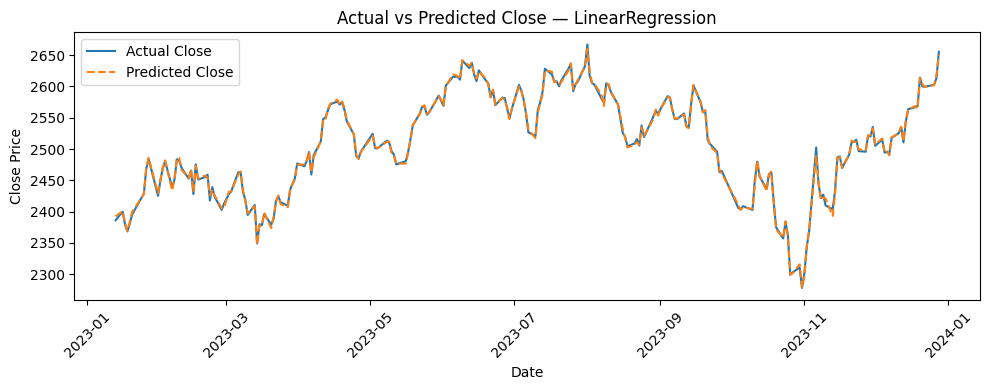

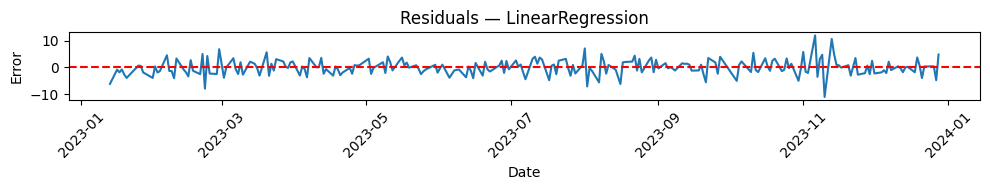


[Ridge] Test MSE=8.4337, MAE=2.2436, R²=0.9987


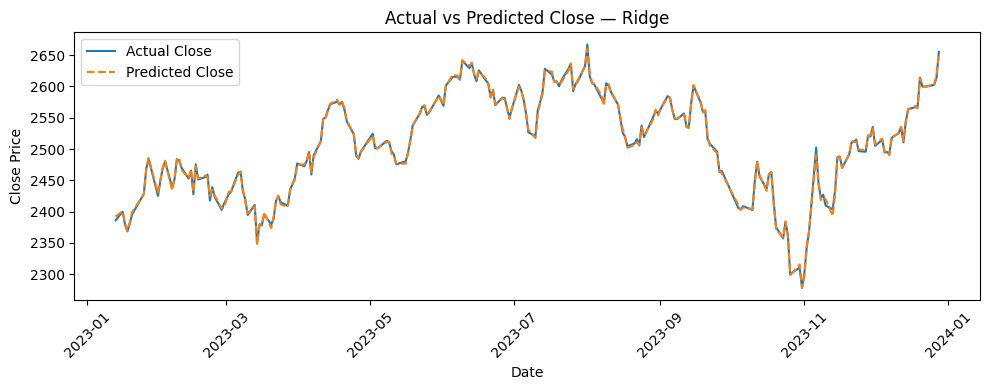

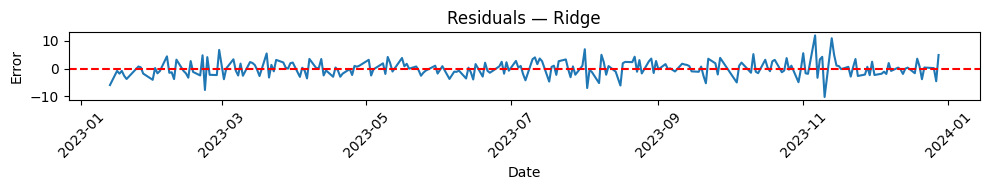


[Lasso] Test MSE=7.9199, MAE=2.1781, R²=0.9988


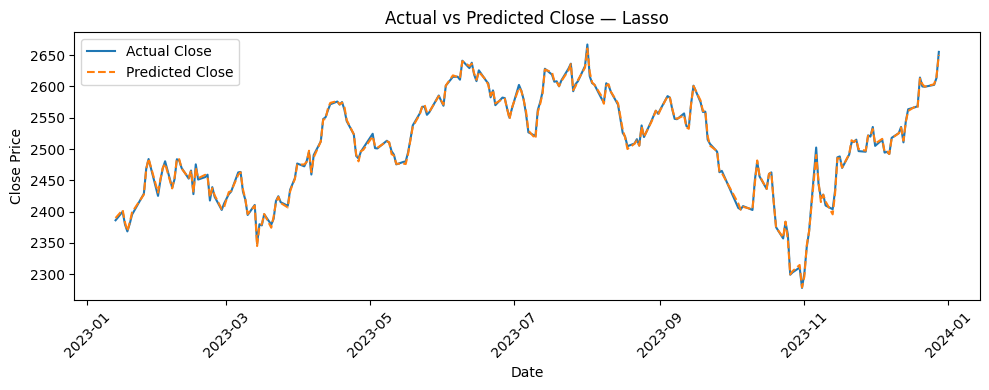

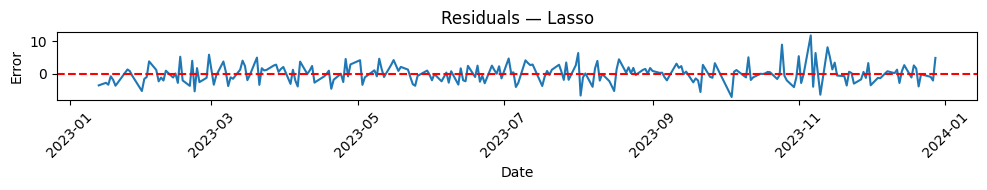


[ElasticNet] Test MSE=10.1572, MAE=2.4709, R²=0.9984


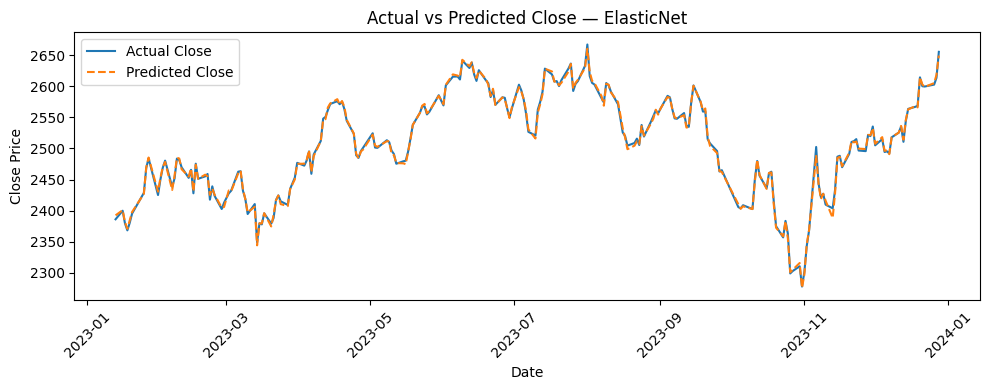

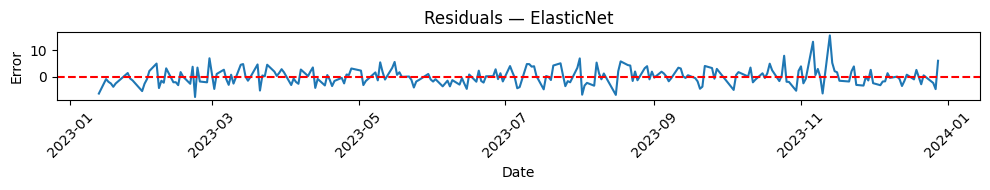


[RandomForest] Test MSE=256.2276, MAE=11.7194, R²=0.9602


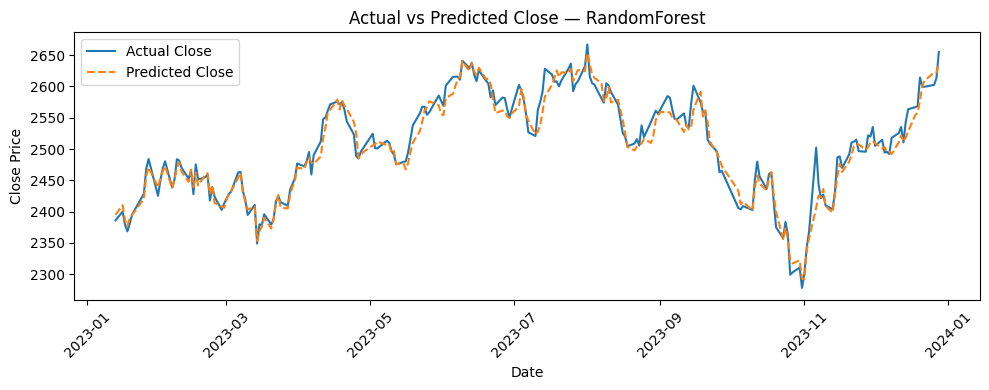

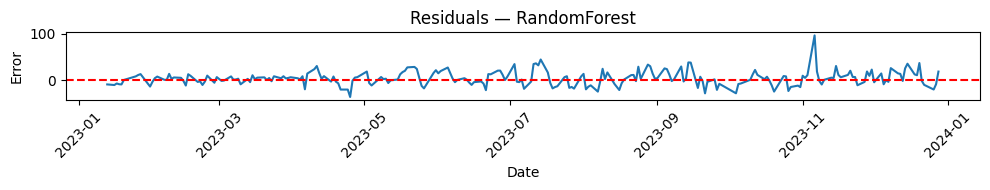

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt

# 1) Load CSV files and sort by date
def read_data(path):
    df = pd.read_csv(path, parse_dates=['Date'])
    df.sort_values('Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

df_train = read_data('/home/kdh02061/quantum/datasets/kospi_train.csv')
df_test  = read_data('/home/kdh02061/quantum/datasets/kospi_test.csv')

# 2) Create lag features (previous 1–3 days’ close, plus 1-day prior OHLCV)
for df in (df_train, df_test):
    df['Prev_Close_1']  = df['Close'].shift(1)
    df['Prev_Close_2']  = df['Close'].shift(2)
    df['Prev_Close_3']  = df['Close'].shift(3)
    df['Prev_Open_1']   = df['Open'].shift(1)
    df['Prev_High_1']   = df['High'].shift(1)
    df['Prev_Low_1']    = df['Low'].shift(1)
    df['Prev_Volume_1'] = df['Volume'].shift(1)

# 3) Add technical indicators
def add_technical(df):
    df['Return_1d'] = df['Close'].pct_change()
    df['MA_5']      = df['Close'].rolling(5).mean()
    df['MA_10']     = df['Close'].rolling(10).mean()
    df['STD_10']    = df['Close'].rolling(10).std()
    df['Mom_5']     = df['Close'] - df['Close'].shift(5)
    # Compute 14-day RSI
    delta     = df['Close'].diff()
    up        = delta.clip(lower=0)
    down      = -delta.clip(upper=0)
    roll_up   = up.ewm(span=14).mean()
    roll_down = down.ewm(span=14).mean()
    rs        = roll_up / roll_down
    df['RSI_14'] = 100 - (100 / (1 + rs))
    return df

df_train = add_technical(df_train)
df_test  = add_technical(df_test)

# 4) One-hot encode day of week
for df in (df_train, df_test):
    df['DayOfWeek'] = df['Date'].dt.weekday
    dummies = pd.get_dummies(df['DayOfWeek'], prefix='WD', drop_first=True)
    df[dummies.columns] = dummies

# 5) Remove rows with NaNs (from shifting/rolling)
train = df_train.dropna().reset_index(drop=True)
test  = df_test .dropna().reset_index(drop=True)

# 6) Define feature list (to use consistently in train & test)
features = [
    'Prev_Open_1','Prev_High_1','Prev_Low_1','Prev_Volume_1',
    'Prev_Close_1','Prev_Close_2','Prev_Close_3',
    'Return_1d','MA_5','MA_10','STD_10','Mom_5','RSI_14'
] + [c for c in train.columns if c.startswith('WD_')]

# 7) Prepare training and test datasets
X_train, y_train = train[features], train['Close']
X_test,  y_test  = test [features],  test ['Close']

# 8) Define models and hyperparameter grids
tscv = TimeSeriesSplit(n_splits=5)
models = {
    'LinearRegression': (
        Pipeline([('scaler', StandardScaler()),
                  ('lr', LinearRegression())]),
        {}
    ),
    'Ridge': (
        Pipeline([('scaler', StandardScaler()),
                  ('ridge', Ridge())]),
        {'ridge__alpha': [0.01, 0.1, 1.0, 10.0]}
    ),
    'Lasso': (
        Pipeline([('scaler', StandardScaler()),
                  ('lasso', Lasso(max_iter=50000, tol=1e-4))]),
        {'lasso__alpha': [0.001, 0.01, 0.1, 1.0]}
    ),
    'ElasticNet': (
        Pipeline([('scaler', StandardScaler()),
                  ('en', ElasticNet(max_iter=50000, tol=1e-4))]),
        {'en__alpha': [0.001, 0.01, 0.1, 1.0],
         'en__l1_ratio': [0.2, 0.5, 0.8]}
    ),
    'RandomForest': (
        RandomForestRegressor(random_state=42),
        {'n_estimators': [100, 200],
         'max_depth':    [3, 5, 10]}
    )
}

# 9) Fit each model via GridSearchCV & store the best estimator
best_models = {}
for name, (est, params) in models.items():
    gs = GridSearchCV(est, params,
                      cv=tscv,
                      scoring='neg_mean_squared_error',
                      n_jobs=-1)
    gs.fit(X_train, y_train)
    best_models[name] = gs.best_estimator_
    cv_rmse = np.sqrt(-gs.best_score_)
    print(f"{name:15} → CV RMSE = {cv_rmse:.4f}")

# 10) Evaluate on test set and visualize results
for name, model in best_models.items():
    # Predict and compute residuals
    y_pred = model.predict(X_test)
    residuals = y_test.values - y_pred

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2  = r2_score(y_test, y_pred)
    print(f"\n[{name}] Test MSE={mse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")

    # Plot actual vs. predicted closing price
    plt.figure(figsize=(10,4))
    plt.plot(test['Date'], y_test,       label='Actual Close')
    plt.plot(test['Date'], y_pred, '--', label='Predicted Close')
    plt.title(f'Actual vs Predicted Close — {name}')
    plt.xlabel('Date'); plt.ylabel('Close Price')
    plt.legend(); plt.xticks(rotation=45); plt.tight_layout()
    plt.show()

    # Plot residuals over time
    plt.figure(figsize=(10,2))
    plt.plot(test['Date'], residuals, label='Residual (Actual – Predicted)')
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Residuals — {name}')
    plt.xlabel('Date'); plt.ylabel('Error')
    plt.xticks(rotation=45); plt.tight_layout()
    plt.show()
